In [1]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# **Loading the dataset**

In [3]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')  
df_sample = df.sample(n=1000, random_state=42)
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# **Preprocessing**

In [4]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower()  
    return text

df_sample['review'] = df_sample['review'].apply(clean_text)


# **Data Distribution**

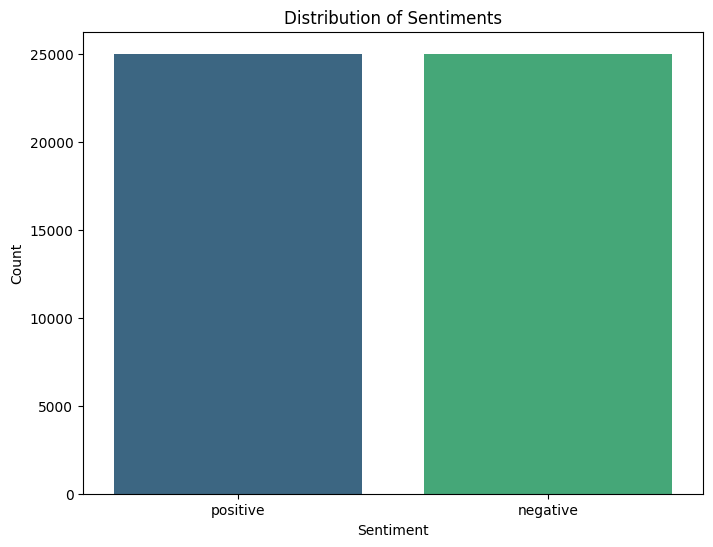

In [12]:
sentiment_counts = df['sentiment'].value_counts()


plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# **Distribution of Review Lengths**

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64


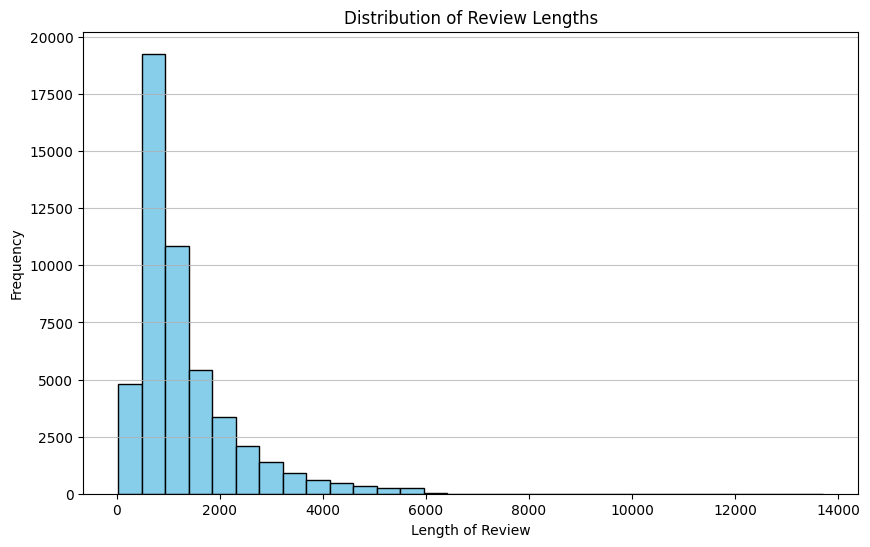

In [13]:

df['review_length'] = df['review'].apply(len)

length_stats = df['review_length'].describe()
print(length_stats)

plt.figure(figsize=(10, 6))
plt.hist(df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# **Word Cloud**

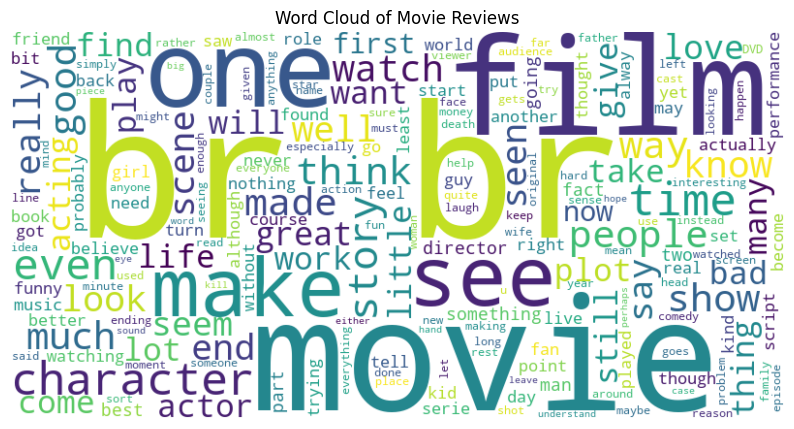

In [14]:
from wordcloud import WordCloud

all_reviews = ' '.join(df['review'])


wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      colormap='viridis', max_words=200).generate(all_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Word Cloud of Movie Reviews')
plt.show()

# **Train-Test-Split**

In [5]:
X = df_sample['review']
y = df_sample['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)  
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=800, test_size=200, random_state=42)


# **Tokenization**

In [6]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


# **Training the Model**

In [9]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32
epochs = 10
history = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), batch_size=batch_size, epochs=epochs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5079 - loss: 0.6935 - val_accuracy: 0.5650 - val_loss: 0.6910
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5600 - loss: 0.6815 - val_accuracy: 0.5100 - val_loss: 0.6934
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8143 - loss: 0.4888 - val_accuracy: 0.6100 - val_loss: 0.8381
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9345 - loss: 0.2098 - val_accuracy: 0.6450 - val_loss: 0.9917
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9542 - loss: 0.1399 - val_accuracy: 0.6300 - val_loss: 0.9725
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9301 - loss: 0.2290 - val_accuracy: 0.6300 - val_loss: 0.9033
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9323 - loss: 0.1887 - val_accuracy: 0.6250 - val_loss: 0.9075
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9619 - loss: 0.1137 - val_accuracy: 0.6400 - v

# **Evaluating**

In [10]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6847 - loss: 1.0968 
Test Accuracy: 0.66


# **Confusion Matrix**

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


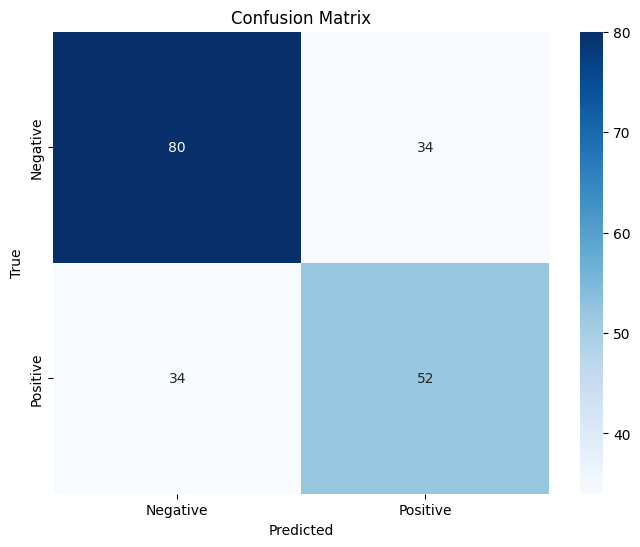

              precision    recall  f1-score   support

    Negative       0.70      0.70      0.70       114
    Positive       0.60      0.60      0.60        86

    accuracy                           0.66       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.66      0.66      0.66       200



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")


conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
